A Notebook for processing experimental results.

All runs correspond to a folder in `outputs/` from which we can load config information and results from json data.

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from transformers import AutoTokenizer
import torch

----

In [2]:
# def plot_logits_at_n(n=1, k=10):
#     fig, axes = plt.subplots(1, 1, figsize=(6, 4))

#     for idx, dist in enumerate(distributions):
#         target_logits = dist[target_slices[idx][0] - 1:target_slices[idx][1] - 1]
#         target_logits = torch.tensor(target_logits)
#         values, indices = torch.topk(target_logits, k, dim=1)
#         axes.plot(values[:, n - 1], linewidth=2.0, alpha=0.75, label=f"Prompt {idx}")

#     axes.set_xlabel("Token position", fontsize=12)
#     axes.set_xticks(range(len(top_k)))
#     axes.set_ylabel("Logit", fontsize=12)

#     axes.set_title(f"Top-{n} logits for each prompt", fontsize=14)

#     return fig, axes

In [3]:
def plot_heatmap(values, indices, tokenizer, idx, show_values=False, show_tokens=False):
    fig, axes = plt.subplots(figsize=(5, 5))

    im = axes.imshow(values, cmap='viridis_r', vmin=7, vmax=30)

    # Show all ticks and label them with the respective list entries
    axes.set_xticks(np.arange(values.shape[1]), minor=False)
    axes.set_yticks(np.arange(values.shape[0]), minor=False)

    axes.set_xlabel("Token position", fontsize=12)
    axes.set_ylabel("Top-k logits", fontsize=12)

    # Loop over data dimensions and create text annotations.
    if show_values:
        texts = values
    if show_tokens:
        texts = indices
    for i in range(texts.shape[0]):
        for j in range(texts.shape[1]):
            if show_values:
                axes.text(j, i, f"{texts[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)
            if show_tokens:
                token = tokenizer._convert_id_to_token(indices[i, j])
                axes.text(j, i, token, ha="center", va="center", color="black", fontsize=8)

    return fig, axes

In [4]:
def get_top_k_logits_for_prompt(distribution, target_slice, k=10):
    target_logits = distribution[target_slice[0] - 1:target_slice[1] - 1]
    target_logits = torch.tensor(target_logits)
    values, indices = torch.topk(target_logits, k, dim=1)
    return values.T, indices.T

----

In [5]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-410m")

/home/nlp/users/mmosba/projects/acr-memorization/.arc-memorization/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [75]:
# Let's look at logits when decoding only the target sequence

file_path = "../outputs/EleutherAI_pythia-410m/generate_target_distributions.npy"
distributions = np.load(file_path) 
print(distributions.shape)

file_path = "../outputs/EleutherAI_pythia-410m/generate_target_target_slices.npy"
target_slices = np.load(file_path) 
print(target_slices.shape)

(5, 256, 50304)
(5, 2)


In [79]:
print(target_slices[0])
target_dist = distributions[0][target_slices[0][0] - 1:target_slices[0][1]]
print(target_dist.shape)


[ 1 12]
(12, 50304)


In [80]:
# Analze logits of target sequence for different prompts

file_path = "../outputs/EleutherAI_pythia-410m/generate_distributions.npy"
distributions = np.load(file_path) 
print(distributions.shape)

file_path = "../outputs/EleutherAI_pythia-410m/generate_target_slices.npy"
target_slices = np.load(file_path) 
print(target_slices.shape)

(5, 256, 50304)
(5, 2)


[ 6 18]
[ 6 18]


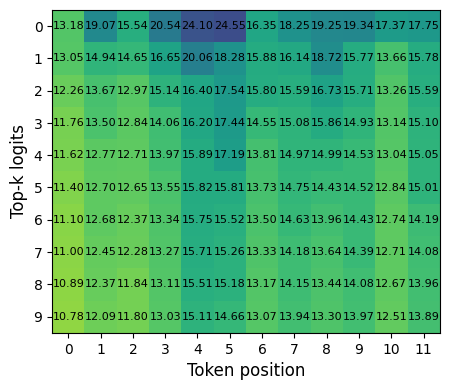

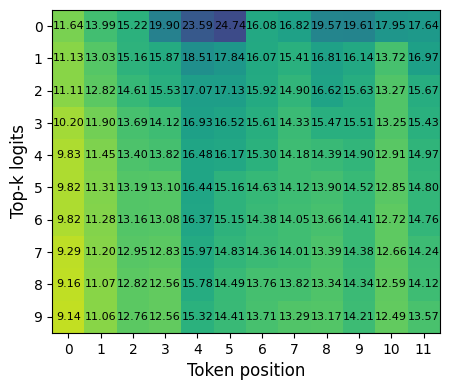

In [69]:
for pidx in range(2):
    print(target_slices[pidx])
    values, indices = get_top_k_logits_for_prompt(distributions[pidx], target_slices[pidx], k=10)
    plot_heatmap(values, indices, tokenizer, pidx, show_values=True)
    # plot_heatmap(values, indices, tokenizer, pidx, show_tokens=True)


In [87]:
# Debugging
import scipy

print(target_slices[0])
dist = distributions[0][target_slices[0][0] - 1:target_slices[0][1] - 1]
print(dist.shape)

[ 6 18]
(12, 50304)


In [88]:
dist

array([[ 7.869397  , -3.3213027 ,  4.5770535 , ..., -3.3143563 ,
        -3.2942557 , -3.276949  ],
       [ 3.8385518 , -1.7920213 ,  0.821061  , ..., -1.8158085 ,
        -1.9095627 , -1.8832222 ],
       [ 2.3984406 , -2.0141556 ,  5.3780136 , ..., -1.9204911 ,
        -1.9033962 , -1.9034016 ],
       ...,
       [ 9.735484  , -0.57185996, 11.607395  , ..., -0.49017113,
        -0.5020294 , -0.45242566],
       [ 3.1133847 , -1.0495784 ,  6.72188   , ..., -1.010421  ,
        -0.93371266, -1.0371029 ],
       [10.854778  , -0.5902262 , 15.778838  , ..., -0.5613676 ,
        -0.5438745 , -0.5600178 ]], dtype=float32)

In [95]:
kl = scipy.stats.entropy(dist, dist, axis=1)
print(kl.shape)

(12,)


In [96]:
kl

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
      dtype=float32)

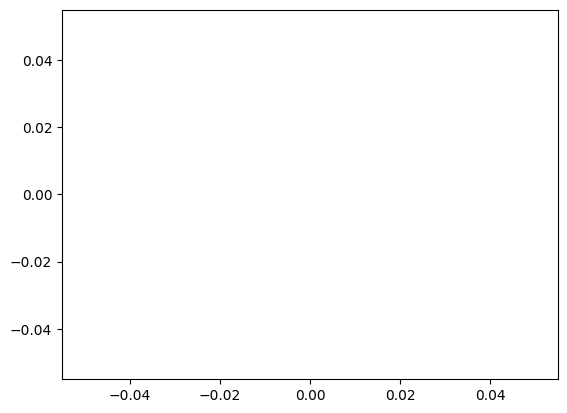

In [97]:
plt.plot(kl)